In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

## Setting seed for replication

In [2]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

## Constants

In [3]:
RESIZE_IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 25

## Loading the dataset

In [4]:
DATA_DIR = Path("../data/chest_xray/")

TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

In [5]:
normal_train_dataset = TRAIN_DIR / 'NORMAL'
pneumonia_train_dataset = TRAIN_DIR / 'PNEUMONIA'

normal_test_dataset = TEST_DIR / 'NORMAL'
pneumonia_test_dataset = TEST_DIR / 'PNEUMONIA'

In [6]:
import cv2
from keras.utils import to_categorical

In [7]:
def parse_folder(dir, data, label):
    for img in dir.glob('*.jpeg'):
        
        try:
            data.append((img, label))
        except Exception as e:
            print('Error ', e)

In [8]:
def get_dataframe():
    data = []
    parse_folder(normal_train_dataset, data, False)
    parse_folder(pneumonia_train_dataset, data, True)
    train_dataset = pd.DataFrame(data, columns=['image', 'label'],index=None)
    #shuffle the dataset
    train_dataset = train_dataset.sample(frac=1.).reset_index(drop=True)

    return train_dataset

In [9]:
train_dataset = get_dataframe()
train_dataset.head(5)
print('Shape=',train_dataset.shape)

Shape= (5232, 2)


## Analysis 

### Distribution of training data

In [10]:
import seaborn as sns

True     3883
False    1349
Name: label, dtype: int64


([<matplotlib.axis.XTick at 0x241cc126ac0>,
 [Text(0, 0, 'Normal'), Text(0, 0, 'Pneumonia')])

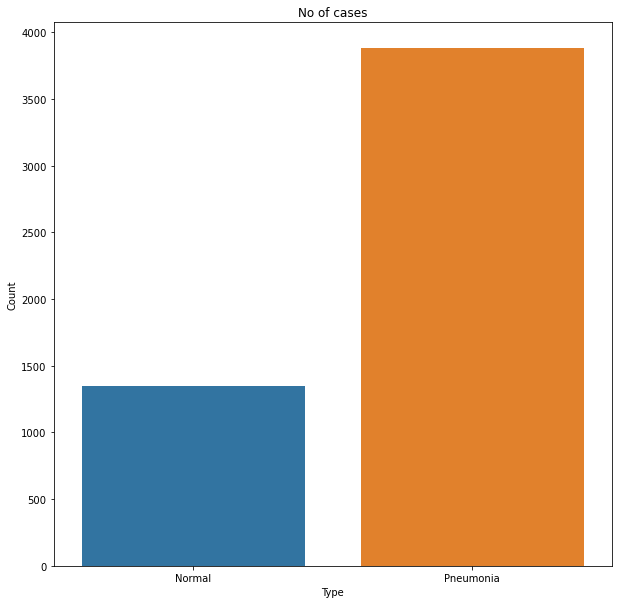

In [11]:
distribution = train_dataset['label'].value_counts()
print(distribution)

plt.figure(figsize=(10, 10))
sns.barplot(x=distribution.index, y=distribution.values)
plt.title('No of cases')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(range(len(distribution)), ['Normal', 'Pneumonia'])

### Correcting Imbalance

In [12]:
# we will try to correct this imbalance by assigning more weight to normal datasets than pneumonia ones
count_pnemonia = distribution[True]
count_normal = distribution[False]
count_total = len(train_dataset)
initial_bias = np.log([count_pnemonia/count_normal])
print('Initial bias = ', initial_bias)

Initial bias =  [1.05724447]


## Preparing data

In [16]:
from keras.preprocessing.image import ImageDataGenerator

In [17]:
weight_for_normal = ((1 / count_normal)*count_total) / 2.0 
weight_for_pneumonia = ((1 / count_pnemonia)*count_total) / 2.0

class_weight = {False: weight_for_normal, True: weight_for_pneumonia}

print('Weight for class normal: {:.2f}'.format(weight_for_normal))
print('Weight for class pneumonia: {:.2f}'.format(weight_for_pneumonia))

Weight for class normal: 1.94
Weight for class pneumonia: 0.67


In [25]:
train_datagen = ImageDataGenerator(
        rescale = 1/255,
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range = 30, 
        zoom_range = 0.2, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip = False,
        vertical_flip=False,
        validation_split=0.2
    )

test_datagen = ImageDataGenerator(rescale = 1/255)

In [26]:
train_generator = train_datagen.flow_from_directory(
                    'data/chest_xray/train',
                    target_size=RESIZE_IMAGE_SIZE,
                    batch_size=BATCH_SIZE,
                    class_mode='binary',
                    subset='training'
                )

validation_generator = train_datagen.flow_from_directory(
    '../data/chest_xray/train', 
    target_size=RESIZE_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation') 

test_generator = test_datagen.flow_from_directory(
                    '../data/chest_xray/test',
                    target_size=RESIZE_IMAGE_SIZE,
                    batch_size=BATCH_SIZE,
                    class_mode='binary'
                )

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Visualization

In [32]:
def visualize(gen):
    x, y = next(gen)
#     print(x.shape, y.shape)

    plt.figure(figsize=(10,10))
    for n in range(20):
        img = x[n]
        ax = plt.subplot(5,5,n+1)
        plt.imshow(img)
        if y[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

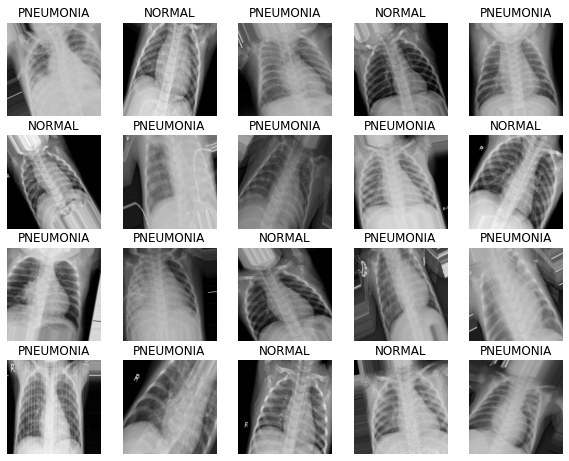

In [33]:
visualize(train_generator)

## Building the model

In [34]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [35]:
def conv_layer(filters):
    block = tf.keras.Sequential([
        Conv2D(filters, (3,3), activation='relu', padding='same' ),
        Conv2D(filters, (3,3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D()
    ])
    
    return block
    
def dense_layer(units, dropout_rate):
    block = tf.keras.Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [36]:
model = Sequential([
    Input(shape=(RESIZE_IMAGE_SIZE[0], RESIZE_IMAGE_SIZE[1], 3)),
    
    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPool2D(),
    
    conv_layer(32),
    conv_layer(64),    
    conv_layer(128),
    Dropout(0.2),
    
    conv_layer(256),
#     MaxPool2D(),
    Dropout(0.2),
    
    Flatten(),
    dense_layer(512, 0.7),
    dense_layer(128, 0.5),
    dense_layer(64, 0.3),
    
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 37, 37, 32)        14016     
_________________________________________________________________
sequential_1 (Sequential)    (None, 18, 18, 64)        55680     
_________________________________________________________________
sequential_2 (Sequential)    (None, 9, 9, 128)         221952    
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 128)        

In [39]:
optimizer = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')], 
              optimizer=optimizer)

# Define the number of steps
no_train_steps =  .samples // BATCH_SIZE
no_val_steps = validation_steps = validation_generator.samples // BATCH_SIZE,

### Fine tuning

In [40]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## Training

In [42]:
history = model.fit(
                    train_generator,
                    epochs=EPOCHS, 
                    steps_per_epoch=no_train_steps,
                    validation_data=validation_generator,
                    callbacks=[es, chkpt, lr_scheduler],
                    class_weight=class_weight)

Epoch 1/25
130/130 [==============================] - 135s 1s/step - loss: 0.3881 - accuracy: 0.8320 - precision: 0.9361 - recall: 0.8305 - val_loss: 0.3637 - val_accuracy: 0.8373 - val_precision: 0.9577 - val_recall: 0.8170 - lr: 0.0100
Epoch 2/25
130/130 [==============================] - 135s 1s/step - loss: 0.3385 - accuracy: 0.8493 - precision: 0.9466 - recall: 0.8447 - val_loss: 0.2851 - val_accuracy: 0.9033 - val_precision: 0.9530 - val_recall: 0.9149 - lr: 0.0089
Epoch 3/25
130/130 [==============================] - 134s 1s/step - loss: 0.2803 - accuracy: 0.8813 - precision: 0.9608 - recall: 0.8757 - val_loss: 0.2887 - val_accuracy: 0.8880 - val_precision: 0.8975 - val_recall: 0.9588 - lr: 0.0079
Epoch 4/25
130/130 [==============================] - 134s 1s/step - loss: 0.2797 - accuracy: 0.8864 - precision: 0.9608 - recall: 0.8829 - val_loss: 0.2983 - val_accuracy: 0.8804 - val_precision: 0.9939 - val_recall: 0.8441 - lr: 0.0071
Epoch 5/25
130/130 [============================

## Visualize performance

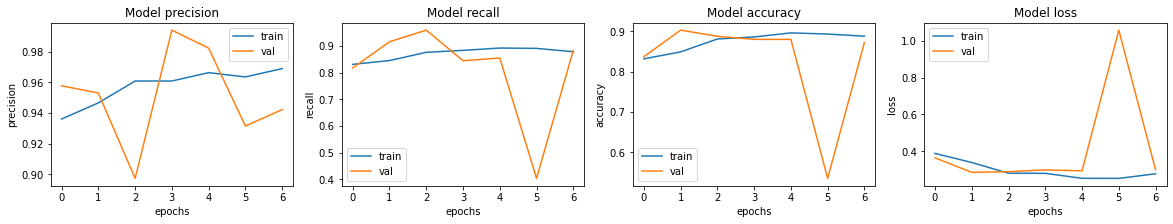

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Validate the model

In [44]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [45]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator, batch_size=BATCH_SIZE)


20/20 [==============================] - 7s 349ms/step - loss: 0.3638 - accuracy: 0.8622 - precision: 0.8878 - recall: 0.8923


In [46]:
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_acc) 
print("Precision on test set: ", test_precision) 
print("Recall on test set: ", test_recall) 

Loss on test set:  0.3638313114643097
Accuracy on test set:  0.8621794581413269
Precision on test set:  0.8877550959587097
Recall on test set:  0.892307698726654


In [50]:
preds = model.predict(test_generator)
y_pred = (preds > 0.5)[:,0]
y_actual = test_generator.class_indices.keys()

In [59]:
y_actual = test_generator.labels
print('Labels ', y_actual[0:5])
print('Predicted ', y_pred[0:5])

Labels  [0 0 0 0 0]
Predicted  [ True False  True  True  True]


<Figure size 432x288 with 0 Axes>

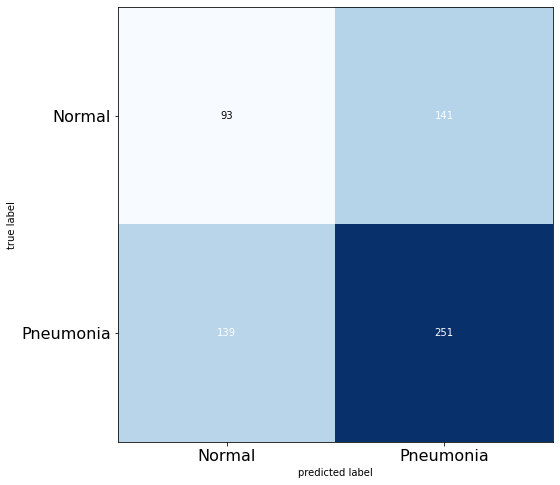

In [60]:
cm  = confusion_matrix(y_actual, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [61]:
model.save('model.h5')